In [1]:
!module load Matlab/2019a

In [2]:
%load_ext autoreload
%autoreload 2

Setup GPUs between jax and matlab

In [2]:
import os
from jax import numpy as jnp
from jwextras.matlab import Matlab 

os.environ["CUDA_VISIBLE_DEVICES"]="5"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".70"
_ = jnp.array([1.]) # Takes GPU for JAX

os.environ["CUDA_VISIBLE_DEVICES"]="6"
mlb = Matlab()
mlb.start()
mlb.run("addpath(pwd)")

Opening new matlab session


In [3]:
import jax
import numpy as np
from matplotlib import pyplot as plt 
from jwave.geometry import kGrid, TimeAxis, Medium, Sources, Sensors
from jwave.signal_processing import apply_ramp
from time import time
from jwave.physics import simulate_wave_propagation

In [4]:
# Defining geometry
def gaussian_window(signal, t, mu, sigma):
    return signal*jnp.exp(
        -(t-mu)**2/sigma**2
    )

def single_src_experiment(size=128, pml_size=20, t_max=1000.):
    N = (size, size)
    dx = (0.5, 0.5)
    cfl = 0.3
    t_max = t_max

    grid = kGrid.make_grid(N, dx)
    
    # Physical properties
    sound_speed = jnp.ones(N) 
    # Physical properties
    medium = Medium(
        sound_speed=sound_speed,
        density=jnp.ones(N),
        attenuation=0.0,
        pml_size=30
    )

    time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=t_max)
    
    # define a source point
    source_freq = 0.2
    source_mag = 5

    t = jnp.arange(0, time_array.t_end, time_array.dt)
    s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
    s1 = gaussian_window(
        apply_ramp(s1, time_array.dt, source_freq),
        t,
        30,
        10
    )

    source_signals = jnp.stack([s1])
    source_positions = ([50],[50])

    sources = Sources(positions=source_positions, signals=source_signals)
    
    ## Run in k-Wave
    print("k-Wave")
    mlb.add(sound_speed, "sound_speed")
    mlb.add(dx[0], "dx")
    mlb.add([x[0] for x in source_positions], "source_location")
    mlb.add(s1, "source_signal")
    mlb.add(time_array.dt, "dt")
    mlb.add(t_max, "t_max")
    mlb.run("[p, exec_t] = kwave_solver(sound_speed, dx, source_location, source_signal, dt, t_max);")
    kwave_exec_time = mlb.get("exec_t")

    ## Run in j-Wave
    print("j-Wave")
    output_taxis = TimeAxis(dt=time_array.t_end, t_end=time_array.t_end)
    
    solver, params = simulate_wave_propagation(
        grid, medium, time_array, sources, backprop=False, output_t_axis=output_taxis, method=None
    )
    
    @jax.jit
    def wave_prop(signal):
        source_signals = jnp.stack([signal])
        params["source_signals"] = source_signals
        return solver(params)

    # Compile
    _ = wave_prop(s1)[1].block_until_ready()
    
    # Execute compiled function
    start_time = time()
    _ = wave_prop(s1)[1].block_until_ready()
    jwave_exec_time = time() - start_time
    
    return kwave_exec_time, jwave_exec_time

In [5]:
k_times = []
j_times = []
sizes = list(map(lambda x: 2**x, range(7,12)))

for size in sizes:
    print(size)
    a, b = single_src_experiment(size)
    k_times.append(a)
    j_times.append(b)

128
k-Wave
j-Wave
256
k-Wave
j-Wave
512
k-Wave
j-Wave
1024
k-Wave
j-Wave
2048
k-Wave
j-Wave


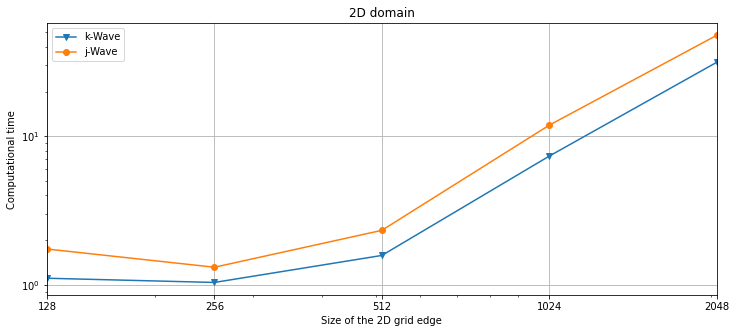

In [6]:
plt.figure(figsize=(12,5))
plt.plot(sizes, k_times, label="k-Wave", marker="v")
plt.plot(sizes, j_times, label="j-Wave", marker="o")
plt.legend()
plt.yscale("log")
plt.xscale("log")
#plt.ylim([0.5,10])
plt.xlabel("Size of the 2D grid edge")
plt.ylabel("Computational time")
plt.xlim([sizes[0], sizes[-1]])
plt.xticks(sizes, list(map(str, sizes)))  # Set text labels.
plt.title("2D domain")
plt.grid()

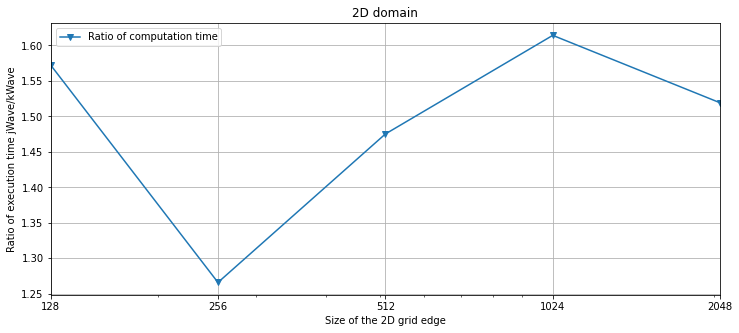

In [7]:
ratio = list(map(lambda x: x[0]/x[1], zip(j_times, k_times)))

plt.figure(figsize=(12,5))
plt.plot(sizes, ratio, label="Ratio of computation time", marker="v")
plt.legend()
#plt.yscale("log")
plt.xscale("log")
#plt.ylim([0.5,10])
plt.xlabel("Size of the 2D grid edge")
plt.ylabel("Ratio of execution time jWave/kWave")
plt.xlim([sizes[0], sizes[-1]])
plt.xticks(sizes, list(map(str, sizes)))  # Set text labels.
plt.title("2D domain")
plt.grid()

In [10]:
def single_src_experiment_3d(size=128, pml_size=20, t_max=300.):
    N = (size, size, size)
    dx = (0.5, 0.5, 0.5)
    cfl = 0.3
    t_max = t_max

    grid = kGrid.make_grid(N, dx)
    
    # Physical properties
    sound_speed = jnp.ones(N) 
    # Physical properties
    medium = Medium(
        sound_speed=sound_speed,
        density=jnp.ones(N),
        attenuation=0.0,
        pml_size=20
    )

    time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=t_max)
    
    # define a source point
    source_freq = 0.2
    source_mag = 5

    t = jnp.arange(0, time_array.t_end, time_array.dt)
    s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
    s1 = gaussian_window(
        apply_ramp(s1, time_array.dt, source_freq),
        t,
        30,
        10
    )

    source_signals = jnp.stack([s1])
    source_positions = ([25],[25],[25])

    sources = Sources(positions=source_positions, signals=source_signals)
    
    ## Run in k-Wave
    print("k-Wave")
    mlb.add(sound_speed, "sound_speed")
    mlb.add(dx[0], "dx")
    mlb.add([x[0] for x in source_positions], "source_location")
    mlb.add(s1, "source_signal")
    mlb.add(time_array.dt, "dt")
    mlb.add(t_max, "t_max")
    mlb.run("[p, exec_t] = kwave_solver_3D(sound_speed, dx, source_location, source_signal, dt, t_max);")
    kwave_exec_time = mlb.get("exec_t")
    
    ## Run in j-Wave
    print("j-Wave")
    output_taxis = TimeAxis(dt=time_array.t_end, t_end=time_array.t_end)
    
    solver, params = simulate_wave_propagation(
        grid, medium, time_array, sources, backprop=False, output_t_axis=output_taxis, method=None
    )
    
    @jax.jit
    def wave_prop(signal):
        source_signals = jnp.stack([signal])
        params["source_signals"] = source_signals
        return solver(params)

    # Compile
    _ = wave_prop(s1)[1].block_until_ready()
    
    # Execute compiled function
    start_time = time()
    _ = wave_prop(s1)[1].block_until_ready()
    jwave_exec_time = time() - start_time
    
    return kwave_exec_time, jwave_exec_time

In [11]:
k_times = []
j_times = []
sizes = list(map(lambda x: 2**x, range(6,9)))

for size in sizes:
    print(size)
    a, b = single_src_experiment_3d(size)
    k_times.append(a)
    j_times.append(b)

64
k-Wave
j-Wave
128
k-Wave
j-Wave
256
k-Wave
j-Wave


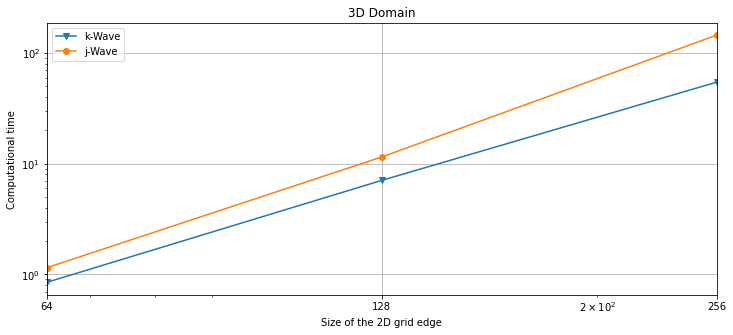

In [12]:
plt.figure(figsize=(12,5))
plt.plot(sizes, k_times, label="k-Wave", marker="v")
plt.plot(sizes, j_times, label="j-Wave", marker="o")
plt.legend()
plt.yscale("log")
plt.xscale("log")
#plt.ylim([0.5,10])
plt.xlabel("Size of the 2D grid edge")
plt.ylabel("Computational time")
plt.xlim([sizes[0], sizes[-1]])
plt.xticks(sizes, list(map(str, sizes)))  # Set text labels.
plt.title("3D Domain")
plt.grid()

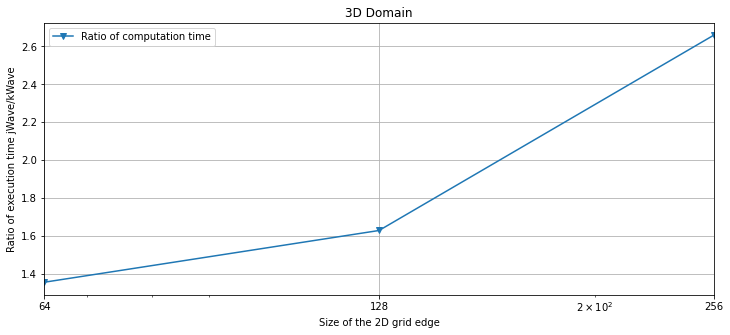

In [13]:
ratio = list(map(lambda x: x[0]/x[1], zip(j_times, k_times)))

plt.figure(figsize=(12,5))
plt.plot(sizes, ratio, label="Ratio of computation time", marker="v")
plt.legend()
#plt.yscale("log")
plt.xscale("log")
#plt.ylim([0.5,10])
plt.xlabel("Size of the 2D grid edge")
plt.ylabel("Ratio of execution time jWave/kWave")
plt.xlim([sizes[0], sizes[-1]])
plt.xticks(sizes, list(map(str, sizes)))  # Set text labels.
plt.title("3D Domain")
plt.grid()

In [14]:
k_times = []
j_times = []
endtime = [200., 300., 400., 500., 750., 1000., 2000., 5000.]

for t_max in endtime:
    print(t_max)
    a, b = single_src_experiment(512, t_max=t_max)
    k_times.append(a)
    j_times.append(b)

200.0
k-Wave
j-Wave
300.0
k-Wave
j-Wave
400.0
k-Wave
j-Wave
500.0
k-Wave
j-Wave
750.0
k-Wave
j-Wave
1000.0
k-Wave
j-Wave
2000.0
k-Wave
j-Wave
5000.0
k-Wave
j-Wave


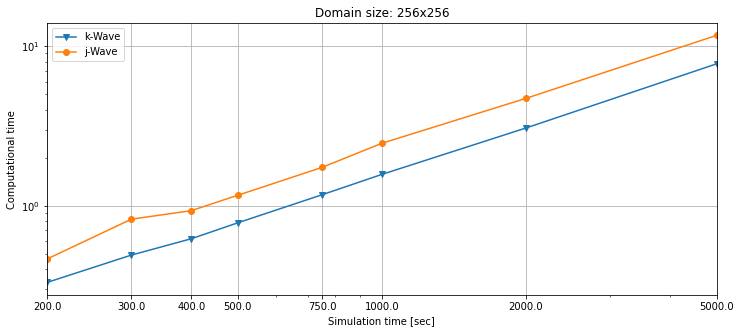

In [15]:
plt.figure(figsize=(12,5))
plt.plot(endtime, k_times, label="k-Wave", marker="v")
plt.plot(endtime, j_times, label="j-Wave", marker="o")
plt.legend()
plt.yscale("log")
plt.xscale("log")
#plt.ylim([0.5,10])
plt.xlabel("Simulation time [sec]")
plt.ylabel("Computational time")
plt.xlim([endtime[0], endtime[-1]])
plt.xticks(endtime, list(map(str, endtime)))  # Set text labels.
plt.title("Domain size: 256x256")
plt.grid()

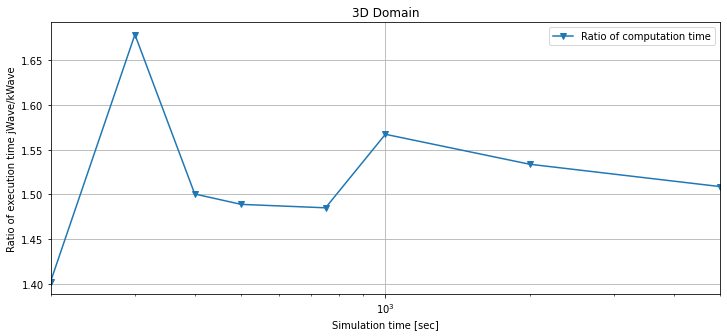

In [16]:
ratio = list(map(lambda x: x[0]/x[1], zip(j_times, k_times)))

plt.figure(figsize=(12,5))
plt.plot(endtime, ratio, label="Ratio of computation time", marker="v")
plt.legend()
#plt.yscale("log")
plt.xscale("log")
#plt.ylim([0.5,10])
plt.xlabel("Simulation time [sec]")
plt.ylabel("Ratio of execution time jWave/kWave")
plt.xlim([endtime[0], endtime[-1]])
plt.title("3D Domain")
plt.grid()

In [17]:
len(j_times)

8

In [77]:
N = (512, 512)
dx = (0.5, 0.5)
cfl = 0.3
t_max = 100.

grid = kGrid.make_grid(N, dx)

# Physical properties
sound_speed = jnp.ones(N) 
# Physical properties
medium = Medium(
    sound_speed=sound_speed,
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=30
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=t_max)

# define a source point
source_freq = 0.2
source_mag = 5

t = jnp.arange(0, time_array.t_end, time_array.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_array.dt, source_freq),
    t,
    30,
    10
)

source_signals = jnp.stack([s1])
source_positions = ([256],[256])

sources = Sources(positions=source_positions, signals=source_signals)

In [78]:
source_signals.shape

(1, 667)

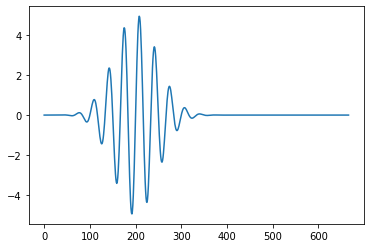

In [79]:
plt.plot(s1)

In [80]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [81]:
mlb = Matlab()
mlb.start()

Opening new matlab session


In [82]:
mlb.run("addpath(pwd)")

In [83]:
mlb.add(sound_speed, "sound_speed")
mlb.add(dx[0], "dx")
mlb.add([x[0] for x in source_positions], "source_location")
mlb.add(s1, "source_signal")
mlb.add(time_array.dt, "dt")
mlb.add(t_max, "t_max")

In [84]:
mlb.run("[p, exec_t] = kwave_solver(sound_speed, dx, source_location, source_signal, dt, t_max);")

In [85]:
p = np.array(mlb.get("p"))

In [86]:
p = np.reshape(p, N)

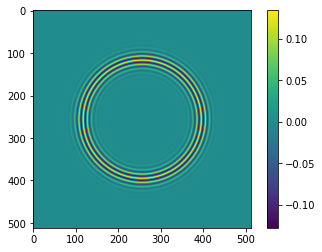

In [87]:
plt.imshow(p)
plt.colorbar()

In [88]:
mlb.get("exec_t")

0.18

In [89]:
mlb.stop()

In [90]:
513//2 + 1

257

In [91]:
# Run simulation
from jwave.physics import simulate_wave_propagation

output_taxis = TimeAxis(dt=time_array.t_end, t_end=time_array.t_end)
fields = simulate_wave_propagation(grid, medium, time_array, sources, backprop=False, output_t_axis=output_taxis)
u = fields[0]
p_jwave = jnp.sum(fields[-1],1)*(medium.sound_speed**2)

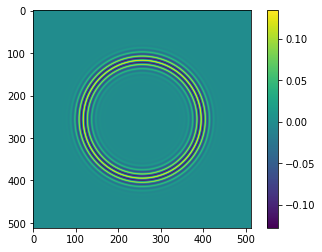

In [92]:
plt.imshow(p_jwave[-2])
plt.colorbar()

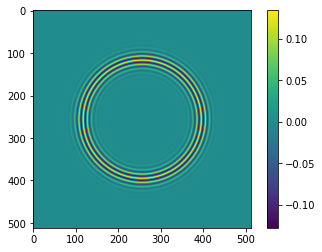

In [93]:
plt.imshow(p)
plt.colorbar()

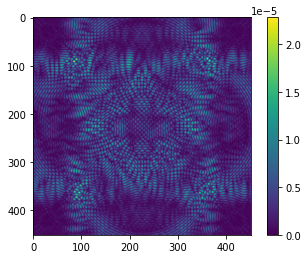

In [94]:
plt.imshow(jnp.abs(p - p_jwave[-1])[30:-30,30:-30]/jnp.amax(jnp.abs(p)))
plt.colorbar()

# Profiling

In [95]:
import jax

sim = jax.jit(
    lambda x: simulate_wave_propagation(
        grid, x, time_array, sources, backprop=False, output_t_axis=output_taxis
    )
)

In [96]:
from timeit import timeit

In [97]:
!pwd

/home/astanziola/repos/jwave/tests/benchmark


In [101]:
jax.profiler.start_server(8892)

In [102]:
jax.profiler.start_trace("./")

fields = sim(medium)
x = fields[0].block_until_ready()


In [103]:
jax.profiler.stop_trace()